# <a id="1">Introduction</a>  

The datasets contains transactions made by credit cards in **September 2013** by european cardholders. This dataset presents transactions that occurred in two days, where we have **492 frauds** out of **284,807 transactions**. The dataset is **highly unbalanced**, the **positive class (frauds)** account for **0.172%** of all transactions.  

It contains only numerical input variables which are the result of a **PCA transformation**.   

Due to confidentiality issues, there are not provided the original features and more background information about the data.  

* Features **V1**, **V2**, ... **V28** are the **principal components** obtained with **PCA**;  
* The only features which have not been transformed with PCA are **Time** and **Amount**. Feature **Time** contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature **Amount** is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.   
* Feature **Class** is the response variable and it takes value **1** in case of fraud and **0** otherwise.  



# <a id="2">Load packages</a>

In [3]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

import os



/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



# <a id="3">Read the data</a>

In [4]:
data_df = pd.read_csv("datasetForFinalAssignment.csv")

# <a id="4">Check the data</a>

In [5]:
print("Credit Card Fraud Detection data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Credit Card Fraud Detection data -  rows: 74691  columns: 14


## <a id="41">Glimpse the data</a>

We start by looking to the data features (first 5 rows).

In [6]:
data_df.head()

,Column 1,user_id,signup_time,purchase_time,signup_time-purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,N[device_id]
0,149671,285108,07/15/2015 4:36 AM,09/10/2015 2:17 PM,82661,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,2
1,84546,229053,01/07/2015 1:19 PM,01/09/2015 10:12 AM,2693,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,1
2,35978,108439,02/08/2015 9:11 PM,04/09/2015 2:26 PM,85995,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,1
3,103053,178528,04/20/2015 8:19 PM,08/03/2015 8:17 PM,151198,35,HUFZWLDYJPRCK,SEO,Chrome,F,30,2.550204e+09,0,1
4,101025,70424,07/05/2015 4:54 PM,08/25/2015 4:08 PM,73394,43,YDLNPVEWMTMMZ,Direct,IE,M,40,3.310808e+09,0,1


Let's look into more details to the data.

In [8]:
data_df.describe()

,Column 1,user_id,signup_time-purchase_time,purchase_value,age,ip_address,class,N[device_id]
count,74691.000000,74691.000000,74691.000000,74691.000000,74691.000000,7.469100e+04,74691.000000,74691.000000
mean,75637.681648,200530.574567,82187.398428,36.885421,33.139120,2.151503e+09,0.093813,1.535419
std,43636.921472,115210.482959,52099.805375,18.355692,8.639987,1.245564e+09,0.291571,2.079428
min,1.000000,8.000000,0.000000,9.000000,18.000000,1.058185e+05,0.000000,1.000000
25%,37815.000000,101344.000000,36380.500000,22.000000,27.000000,1.090013e+09,0.000000,1.000000
50%,75818.000000,200195.000000,81774.000000,34.000000,33.000000,2.155904e+09,0.000000,1.000000
75%,113376.500000,300729.500000,127365.500000,49.000000,39.000000,3.235917e+09,0.000000,1.000000
max,151108.000000,399993.000000,172799.000000,129.000000,76.000000,4.294850e+09,1.000000,19.000000


Looking to the **Time** feature, we can confirm that the data contains **284,807** transactions, during 2 consecutive days (or **172792** seconds).

## <a id="42">Check missing data</a>  

Let's check if there is any missing data.

In [9]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,N[device_id],class,ip_address,age,sex,browser,source,device_id,purchase_value,signup_time-purchase_time,purchase_time,signup_time,user_id,Column 1
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is no missing data in the entire dataset.

## <a id="43">Data unbalance</a>

Let's check data unbalance with respect with *target* value, i.e. **Class**.

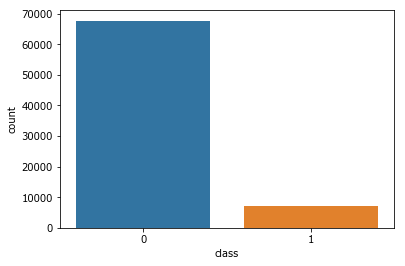

In [11]:
sns.countplot(data=data_df,x="class")

Only **492** (or **0.172%**) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable **Class**.

# <a id="5">Data exploration</a>

## Transactions amount

## Features correlation

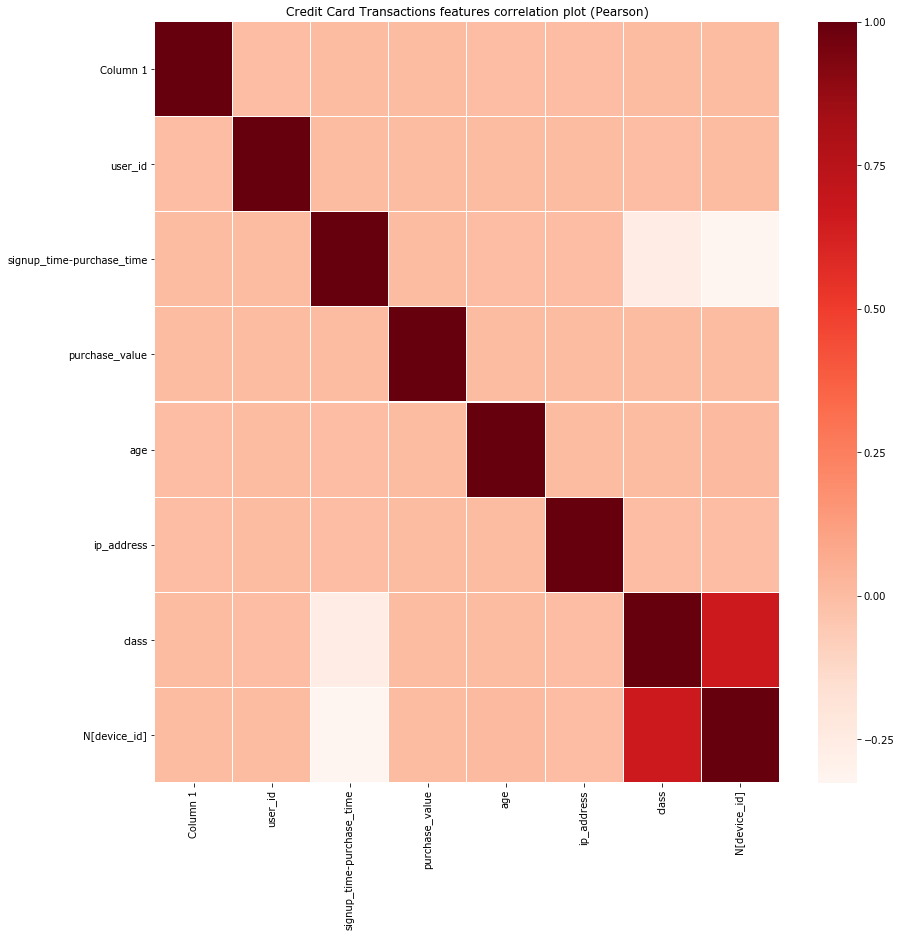

In [14]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

# <a id="6">Predictive models</a>  



### Define predictors and target values

Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

In [24]:
target = 'class'
predictors = ["signup_time-purchase_time","purchase_value","N[device_id]"]

### Split data in train, test and validation set

Let's define train, validation and test sets.

In [25]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

Let's start with a RandomForrestClassifier <a href='#8'>[3]</a>   model.

## <a id="61">RandomForestClassifier</a>


### Define model parameters

Let's set the parameters for the model.

Let's run a model using the training set for training. Then, we will use the validation set for validation. 

We will use as validation criterion **GINI**, which formula is **GINI = 2 * (AUC) - 1**, where **AUC** is the **Receiver Operating Characteristic - Area Under Curve (ROC-AUC)** <a href='#8'>[4]</a>.  Number of estimators is set to **100** and number of parallel jobs is set to **4**.

We start by initializing the RandomForestClassifier.

In [26]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

Let's train the **RandonForestClassifier** using the **train_df** data and **fit** function.

In [27]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2018, verbose=False,
            warm_start=False)

Let's now predict the **target** values for the **valid_df** data, using **predict** function.

In [28]:
preds = clf.predict(valid_df[predictors])

Let's also visualize the features importance.

### Features importance

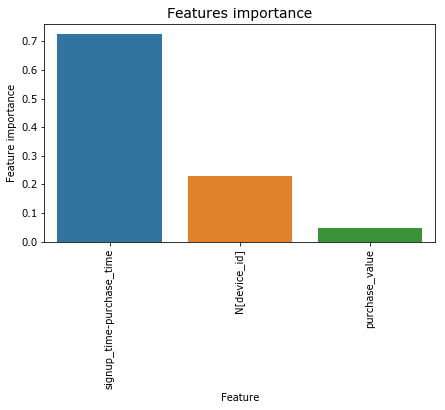

In [29]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   


The most important features are **V17**, **V12**, **V14**, **V10**, **V11**, **V16**.


### Confusion matrix

Let's show a confusion matrix for the results we obtained. 

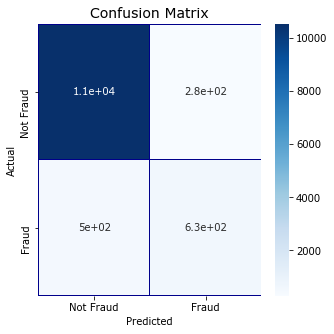

In [30]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [31]:
roc_auc_score(valid_df[target].values, preds)

0.7669754390931317

The **ROC-AUC** score obtained with **RandomForrestClassifier** is **0.85**.





## <a id="62">AdaBoostClassifier</a>


AdaBoostClassifier stands for Adaptive Boosting Classifier <a href='#8'>[5]</a>.

### Prepare the model

Let's set the parameters for the model and initialize the model.

In [32]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

### Fit the model

Let's fit the model.

In [33]:
clf.fit(train_df[predictors], train_df[target].values)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.8, n_estimators=100, random_state=2018)

### Predict the target values

Let's now predict the **target** values for the **valid_df** data, using predict function.

In [34]:
preds = clf.predict(valid_df[predictors])

### Features importance

Let's see also the features importance.

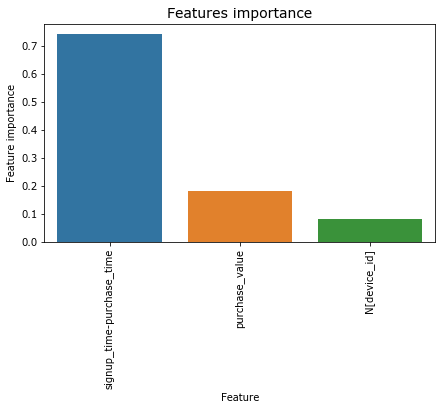

In [35]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

### Confusion matrix

Let's visualize the confusion matrix.

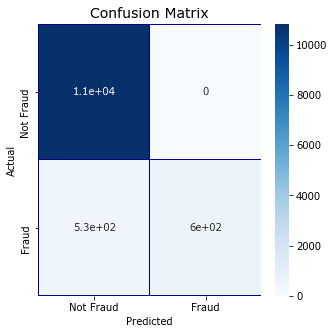

In [36]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

Let's calculate also the ROC-AUC.


### Area under curve

In [37]:
roc_auc_score(valid_df[target].values, preds)

0.7655141843971631

The ROC-AUC score obtained with AdaBoostClassifier is **0.83**.

## <a id="63">CatBoostClassifier</a>


CatBoostClassifier is a gradient boosting for decision trees algorithm with support for handling categorical data <a href='#8'>[6]</a>.

### Prepare the model

Let's set the parameters for the model and initialize the model.

In [40]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             
                             od_wait=100)

In [41]:
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 313ms	remaining: 2m 36s
1:	total: 679ms	remaining: 2m 49s
2:	total: 1.97s	remaining: 5m 26s
3:	total: 3.14s	remaining: 6m 29s
4:	total: 4.29s	remaining: 7m 5s
5:	total: 5.45s	remaining: 7m 28s
6:	total: 6.59s	remaining: 7m 44s
7:	total: 7.84s	remaining: 8m 2s
8:	total: 7.95s	remaining: 7m 13s
9:	total: 8.02s	remaining: 6m 32s
10:	total: 9.17s	remaining: 6m 47s
11:	total: 9.24s	remaining: 6m 15s
12:	total: 10.4s	remaining: 6m 28s
13:	total: 10.5s	remaining: 6m 4s
14:	total: 11.6s	remaining: 6m 15s
15:	total: 12s	remaining: 6m 2s
16:	total: 12.2s	remaining: 5m 46s
17:	total: 13.4s	remaining: 5m 57s
18:	total: 13.4s	remaining: 5m 40s
19:	total: 14.6s	remaining: 5m 50s
20:	total: 15.7s	remaining: 5m 58s
21:	total: 15.8s	remaining: 5m 43s
22:	total: 16.9s	remaining: 5m 51s
23:	total: 17s	remaining: 5m 37s
24:	total: 18.1s	remaining: 5m 44s
25:	total: 18.3s	remaining: 5m 33s
26:	total: 19.8s	remaining: 5m 46s
27:	total: 20s	remaining: 5m 37s
28:	total: 21.1s	remaining: 5m 42s
29:	t

232:	total: 2m 5s	remaining: 2m 24s
233:	total: 2m 7s	remaining: 2m 24s
234:	total: 2m 7s	remaining: 2m 23s
235:	total: 2m 7s	remaining: 2m 22s
236:	total: 2m 8s	remaining: 2m 22s
237:	total: 2m 9s	remaining: 2m 22s
238:	total: 2m 9s	remaining: 2m 21s
239:	total: 2m 9s	remaining: 2m 20s
240:	total: 2m 10s	remaining: 2m 20s
241:	total: 2m 11s	remaining: 2m 20s
242:	total: 2m 11s	remaining: 2m 19s
243:	total: 2m 11s	remaining: 2m 18s
244:	total: 2m 11s	remaining: 2m 17s
245:	total: 2m 11s	remaining: 2m 16s
246:	total: 2m 12s	remaining: 2m 15s
247:	total: 2m 12s	remaining: 2m 14s
248:	total: 2m 12s	remaining: 2m 13s
249:	total: 2m 12s	remaining: 2m 12s
250:	total: 2m 13s	remaining: 2m 12s
251:	total: 2m 13s	remaining: 2m 11s
252:	total: 2m 13s	remaining: 2m 10s
253:	total: 2m 13s	remaining: 2m 9s
254:	total: 2m 13s	remaining: 2m 8s
255:	total: 2m 13s	remaining: 2m 7s
256:	total: 2m 14s	remaining: 2m 7s
257:	total: 2m 15s	remaining: 2m 6s
258:	total: 2m 16s	remaining: 2m 6s
259:	total: 2m 

458:	total: 3m 52s	remaining: 20.7s
459:	total: 3m 52s	remaining: 20.2s
460:	total: 3m 52s	remaining: 19.7s
461:	total: 3m 52s	remaining: 19.1s
462:	total: 3m 52s	remaining: 18.6s
463:	total: 3m 52s	remaining: 18.1s
464:	total: 3m 52s	remaining: 17.5s
465:	total: 3m 54s	remaining: 17.1s
466:	total: 3m 54s	remaining: 16.6s
467:	total: 3m 54s	remaining: 16.1s
468:	total: 3m 56s	remaining: 15.6s
469:	total: 3m 56s	remaining: 15.1s
470:	total: 3m 56s	remaining: 14.5s
471:	total: 3m 56s	remaining: 14s
472:	total: 3m 56s	remaining: 13.5s
473:	total: 3m 56s	remaining: 13s
474:	total: 3m 56s	remaining: 12.4s
475:	total: 3m 56s	remaining: 11.9s
476:	total: 3m 57s	remaining: 11.5s
477:	total: 3m 57s	remaining: 10.9s
478:	total: 3m 58s	remaining: 10.4s
479:	total: 3m 58s	remaining: 9.95s
480:	total: 3m 58s	remaining: 9.43s
481:	total: 3m 58s	remaining: 8.92s
482:	total: 4m	remaining: 8.45s
483:	total: 4m	remaining: 7.95s
484:	total: 4m	remaining: 7.44s
485:	total: 4m	remaining: 6.93s
486:	total: 

### Predict the target values

Let's now predict the **target** values for the **val_df** data, using predict function.

In [42]:
preds = clf.predict(valid_df[predictors])

### Features importance

Let's see also the features importance.

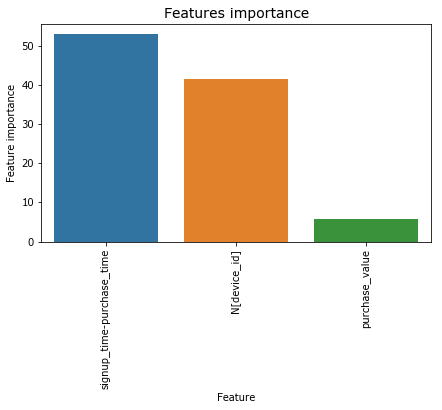

In [43]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

### Confusion matrix

Let's visualize the confusion matrix.

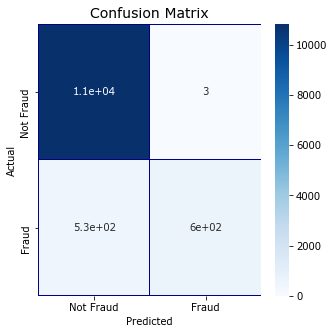

In [44]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

Let's calculate also the ROC-AUC.


### Area under curve

In [45]:
roc_auc_score(valid_df[target].values, preds)

0.7653755906616

The ROC-AUC score obtained with CatBoostClassifier is **0.86**.

## <a id="63">XGBoost</a>

XGBoost is a gradient boosting algorithm <a href='#8'>[7]</a>.

Let's prepare the model.

### Prepare the model

We initialize the DMatrix objects for training and validation, starting from the datasets. We also set some of the parameters used for the model tuning.

In [50]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

ValueError: feature_names may not contain [, ] or <

### Train the model

Let's train the model. 

In [51]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

NameError: name 'params' is not defined

The best validation score (ROC-AUC) was **0.984**, for round **241**.

### Plot variable importance

NameError: name 'model' is not defined

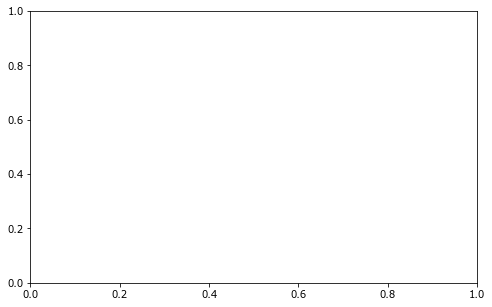

In [52]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

### Predict test set


We used the train and validation sets for training and validation. We will use the trained model now to predict the target value for the test set.

In [53]:
preds = model.predict(dtest)

NameError: name 'model' is not defined

### Area under curve

Let's calculate ROC-AUC.

In [54]:
roc_auc_score(test_df[target].values, preds)

ValueError: Found input variables with inconsistent numbers of samples: [14939, 11951]

The AUC score for the prediction of fresh data (test set) is **0.974**.

## <a id="64">LightGBM</a>


Let's continue with another gradient boosting algorithm, LightGBM <a href='#8'>[8]</a> <a href='#8'>[9]</a>.


### Define model parameters

Let's set the parameters for the model. We will use these parameters only for the first lgb model.

In [55]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

### Prepare the model

Let's prepare the model, creating the **Dataset**s data structures from the train and validation sets.

In [56]:
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

### Run the model

Let's run the model, using the **train** function.

In [57]:
evals_results = {}

model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=2*EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)


Training until validation scores don't improve for 100 rounds.
[50]	train's auc: 0.845983	valid's auc: 0.842716
[100]	train's auc: 0.849769	valid's auc: 0.841435
Early stopping, best iteration is:
[17]	train's auc: 0.844419	valid's auc: 0.844303


Best validation score  was obtained for round **85**, for which **AUC ~= 0.974**.

Let's plot variable importance.

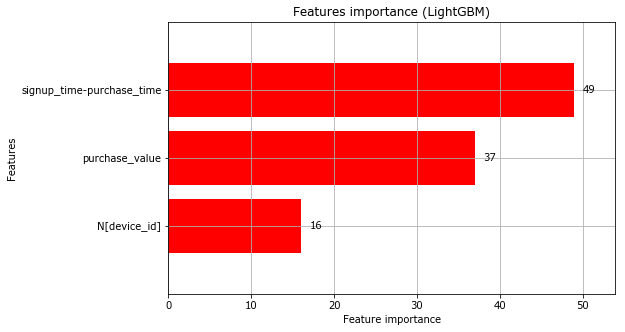

In [58]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

Let's predict now the target for the test data.

### Predict test data

In [59]:
preds = model.predict(test_df[predictors])

### Area under curve

Let's calculate the ROC-AUC score for the prediction.

In [60]:
roc_auc_score(test_df[target].values, preds)

0.825760313135218

The ROC-AUC score obtained for the test set is **0.946**.

### Training and validation using cross-validation

Let's use now cross-validation. We will use cross-validation (KFolds) with 5 folds. Data is divided in 5 folds and, by rotation, we are training using 4 folds (n-1) and validate using the 5th (nth) fold.

Test set is calculated as an average of the predictions 

In [61]:
kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
n_fold = 0
for train_idx, valid_idx in kf.split(train_df):
    train_x, train_y = train_df[predictors].iloc[train_idx],train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx],train_df[target].iloc[valid_idx]
    
    evals_results = {}
    model =  LGBMClassifier(
                  nthread=-1,
                  n_estimators=2000,
                  learning_rate=0.01,
                  num_leaves=80,
                  colsample_bytree=0.98,
                  subsample=0.78,
                  reg_alpha=0.04,
                  reg_lambda=0.073,
                  subsample_for_bin=50,
                  boosting_type='gbdt',
                  is_unbalance=False,
                  min_split_gain=0.025,
                  min_child_weight=40,
                  min_child_samples=510,
                  objective='binary',
                  metric='auc',
                  silent=-1,
                  verbose=-1,
                  feval=None)
    model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose= VERBOSE_EVAL, early_stopping_rounds= EARLY_STOP)
    
    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    test_preds += model.predict_proba(test_df[predictors], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, train_x, train_y, valid_x, valid_y
    gc.collect()
    n_fold = n_fold + 1
train_auc_score = roc_auc_score(train_df[target], oof_preds)
print('Full AUC score %.6f' % train_auc_score)                                    

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.844364	valid_1's auc: 0.82899
Early stopping, best iteration is:
[1]	training's auc: 0.834091	valid_1's auc: 0.832343
Fold  1 AUC : 0.832343
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.841845	valid_1's auc: 0.825741
Early stopping, best iteration is:
[1]	training's auc: 0.833625	valid_1's auc: 0.834001
Fold  2 AUC : 0.834001
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.849516	valid_1's auc: 0.816299
Early stopping, best iteration is:
[1]	training's auc: 0.842648	valid_1's auc: 0.816821
Fold  3 AUC : 0.816821
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.838873	valid_1's auc: 0.838531
Early stopping, best iteration is:
[15]	training's auc: 0.838917	valid_1's auc: 0.839477
Fold  4 AUC : 0.839477
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.847647	

The AUC score for the prediction from the test data was 0.93.

We prepare the test prediction, from the averaged predictions for test over the 5 folds.

In [62]:
pred = test_preds

# <a id="7">Conclusions</a>